In [1]:
%matplotlib inline

In [2]:
from collections import defaultdict
import os
from os.path import join, basename, isfile
from itertools import chain

In [3]:
from matplotlib_hep import histpoints
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import xmltodict
from tqdm import tqdm_notebook

In [4]:
sns.set_style("whitegrid")
sns.set_context("paper")

In [5]:
out_dir = './output/'

In [6]:
def get_alignment(xml_fn):
    with open(xml_fn, 'rt') as f:
        conditions = xmltodict.parse(f.read())['conditions']
    if 'repository' in conditions:
        conditions = conditions['repository']['iov']
    return {
        basename(d['@path']): d['alignment']
        for d in conditions['detelement']
        if not d['@path'].endswith('sensor')
    }

In [7]:
def to_float(s):
    if s.endswith('*mm'):
        return float(s[:-len('*mm')])
    if s.endswith('*rad'):
        return float(s[:-len('*rad')])
    else:
        return float(s)

In [8]:
before = defaultdict(lambda: defaultdict(list))
after = defaultdict(lambda: defaultdict(list))
true = defaultdict(lambda: defaultdict(list))
filenames = {
    'conditions-misaligned.xml': before,
    'Telescope_geom.xml': after,
    'conditions-nominal.xml': true
}
for run in tqdm_notebook(sorted(os.listdir(out_dir), key=int)):
    if not all(isfile(join(out_dir, run, fn)) for fn in filenames):
        print('Skipping:', run)
        continue
    for fn, data in filenames.items():
        for plane, alignment in get_alignment(join(out_dir, run, fn)).items():
            data[plane]['Tx'].append(to_float(alignment['position']['@x']))
            data[plane]['Ty'].append(to_float(alignment['position']['@y']))
            data[plane]['Tz'].append(to_float(alignment['position']['@z']))
            data[plane]['Rx'].append(to_float(alignment['rotation']['@x']))
            data[plane]['Ry'].append(to_float(alignment['rotation']['@y']))
            data[plane]['Rz'].append(to_float(alignment['rotation']['@z']))

Skipping: 5869



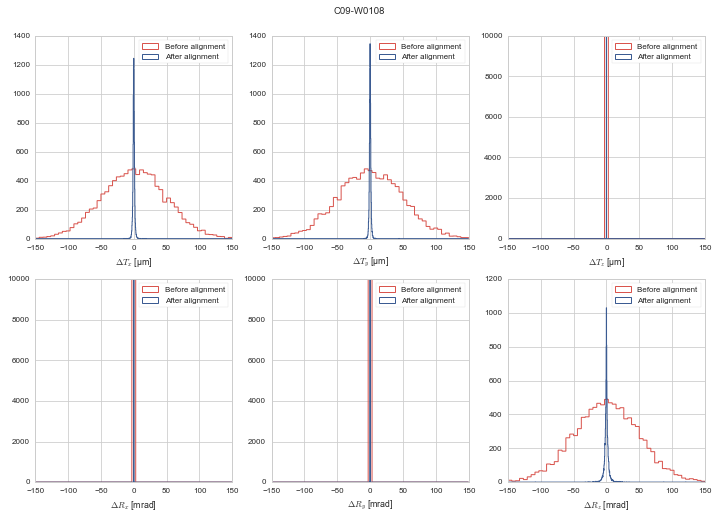

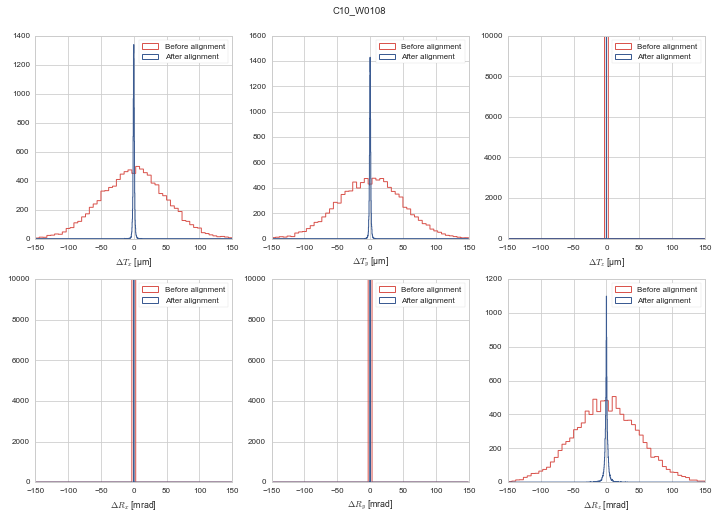

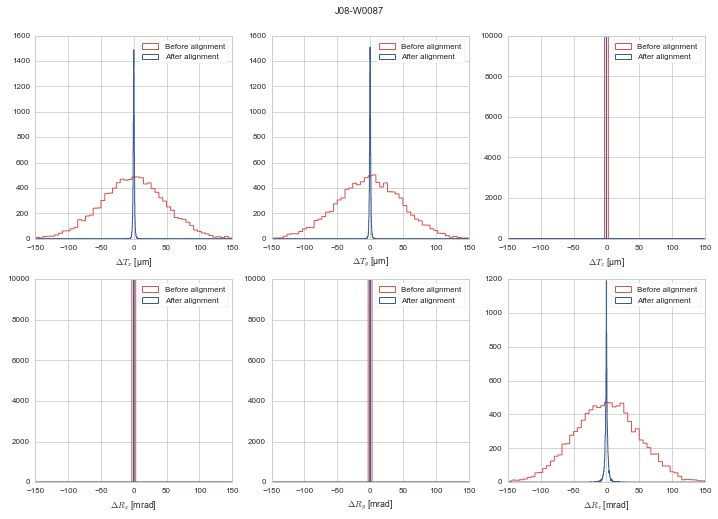

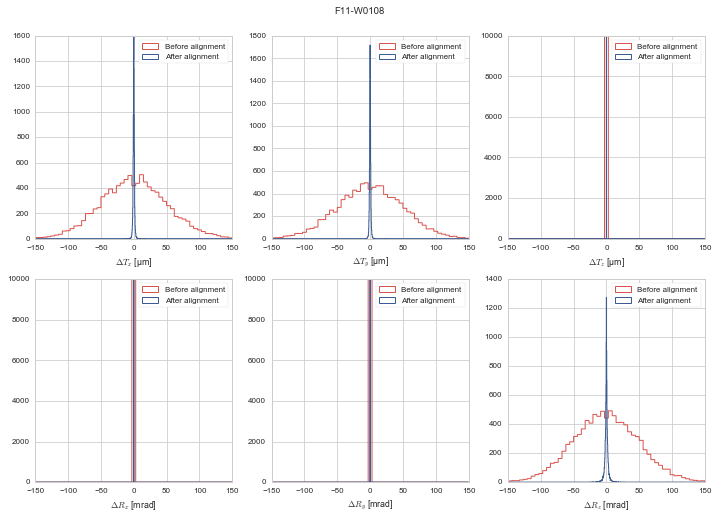

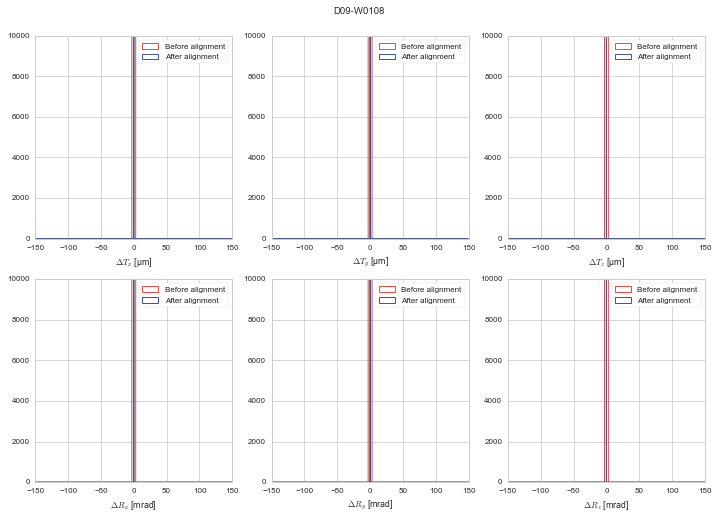

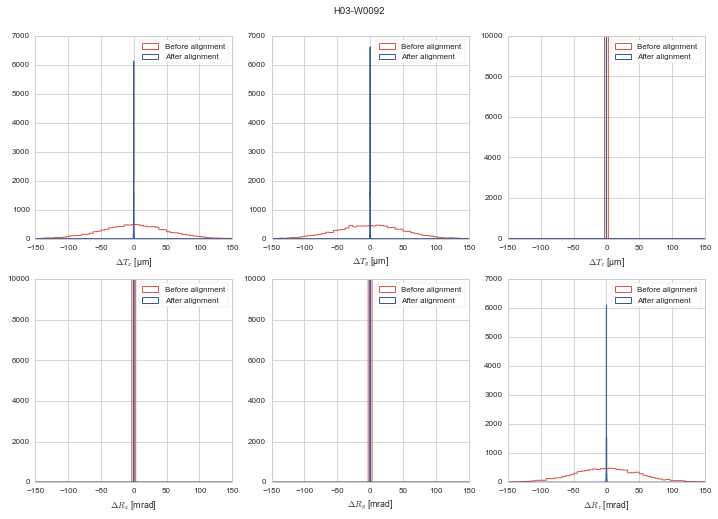

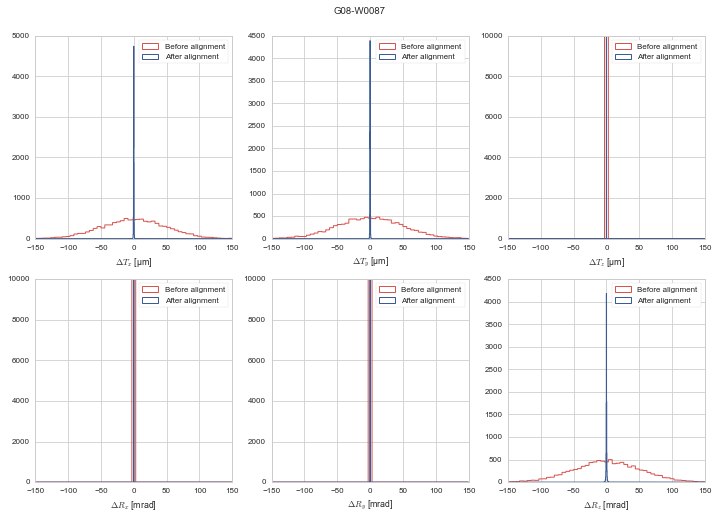

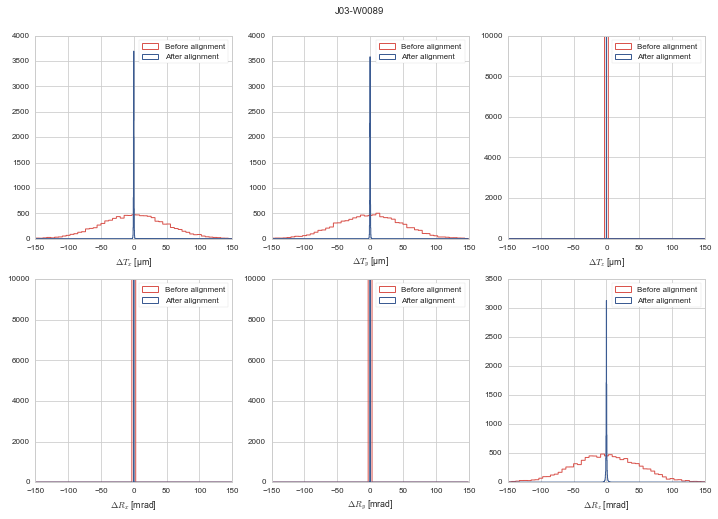

In [9]:
fixed_plane = 'D09-W0108'
dofs = ['Tx', 'Ty', 'Tz', 'Rx', 'Ry', 'Rz']
planes = ['C09-W0108', 'C10_W0108', 'J08-W0087', 'F11-W0108', 'D09-W0108', 'H03-W0092', 'G08-W0087', 'J03-W0089']

for i, plane in enumerate(planes):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    fig.patch.set_alpha(0)
    for var, ax in zip(dofs, chain(*axs)):
        # For now assume this fixed plane is correct
        assert (np.array(before[fixed_plane][var]) == 0).all()
        assert (np.array(after[fixed_plane][var]) == 0).all()
        limits = (-150, 150)
        unit = ['[mrad]', '[μm]'][var[0] == 'T']

        ax.hist(
            np.array(before[plane][var])*1000,
            bins=51, range=limits, label='Before alignment', histtype='step',
            lw=1, color=sns.xkcd_rgb["pale red"]
        )
        ax.hist(
            np.array(after[plane][var])*1000,
            bins=1001, range=limits, label='After alignment', histtype='step',
            lw=1, color=sns.xkcd_rgb["denim blue"]
        )
        ax.set_xlabel('$\Delta '+'_'.join(var)+'$ '+unit)
        ax.legend(loc='best', frameon=True)
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig('bach_plots/'+plane+'_'+var+'.png', dpi=300, bbox_inches=extent.expanded(1.2, 1.2).translated(-0.1, -0.1))
    fig.savefig('bach_plots/'+plane+'.png', bbox_inches='tight')
    fig.suptitle(plane, y=0.95)